# Pre proccessamento de datos

In [7]:
from pathlib import Path

import pandas as pd

data_dir = Path("data").resolve()


df_path = data_dir / "individual_household_electric_power_consumption_cleared.csv"


df = pd.read_csv(
    filepath_or_buffer=df_path,
    sep=";",
    index_col=0,
    parse_dates=True,
    dtype={
        "Global_active_power": "float32",
        "Global_reactive_power": "float32",
        "Voltage": "float32",
        "Global_intensity": "float32",
        "Sub_metering_1": "float32",
        "Sub_metering_2": "float32",
        "Sub_metering_3": "float32",
    },
    na_values=["?"],
)


In [8]:
Y = "Global_active_power"

In [9]:
# Extrair características temporais
from matplotlib import pyplot as plt

df_temporal = df.copy()
df_temporal["hour"] = df_temporal.index.hour
df_temporal["day_of_week"] = df_temporal.index.day_of_week
df_temporal["month"] = df_temporal.index.month
df_temporal["year"] = df_temporal.index.year


# Consumo médio por hora
hourly_avg = df_temporal.groupby("hour")[Y].mean()

# Consumo médio por dia da semana
daily_avg = df_temporal.groupby("day_of_week")[Y].mean()
day_names = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]

# Consumo médio por mês
monthly_avg = df_temporal.groupby("month")[Y].mean()

print("=== PADRÕES TEMPORAIS ===")
print(f"Hora de maior consumo: {hourly_avg.idxmax()}h ({hourly_avg.max():.3f} kW)")
print(f"Hora de menor consumo: {hourly_avg.idxmin()}h ({hourly_avg.min():.3f} kW)")
print(
    f"Dia da semana com maior consumo: {day_names[daily_avg.idxmax()]} ({daily_avg.max():.3f} kW)"
)
print(
    f"Dia da semana com menor consumo: {day_names[daily_avg.idxmin()]} ({daily_avg.min():.3f} kW)"
)
print(f"Mês de maior consumo: {monthly_avg.idxmax()} ({monthly_avg.max():.3f} kW)")
print(f"Mês de menor consumo: {monthly_avg.idxmin()} ({monthly_avg.min():.3f} kW)")


=== PADRÕES TEMPORAIS ===
Hora de maior consumo: 20h (1.899 kW)
Hora de menor consumo: 4h (0.444 kW)
Dia da semana com maior consumo: Sáb (1.248 kW)
Dia da semana com menor consumo: Qui (0.982 kW)
Mês de maior consumo: 12 (1.490 kW)
Mês de menor consumo: 8 (0.573 kW)


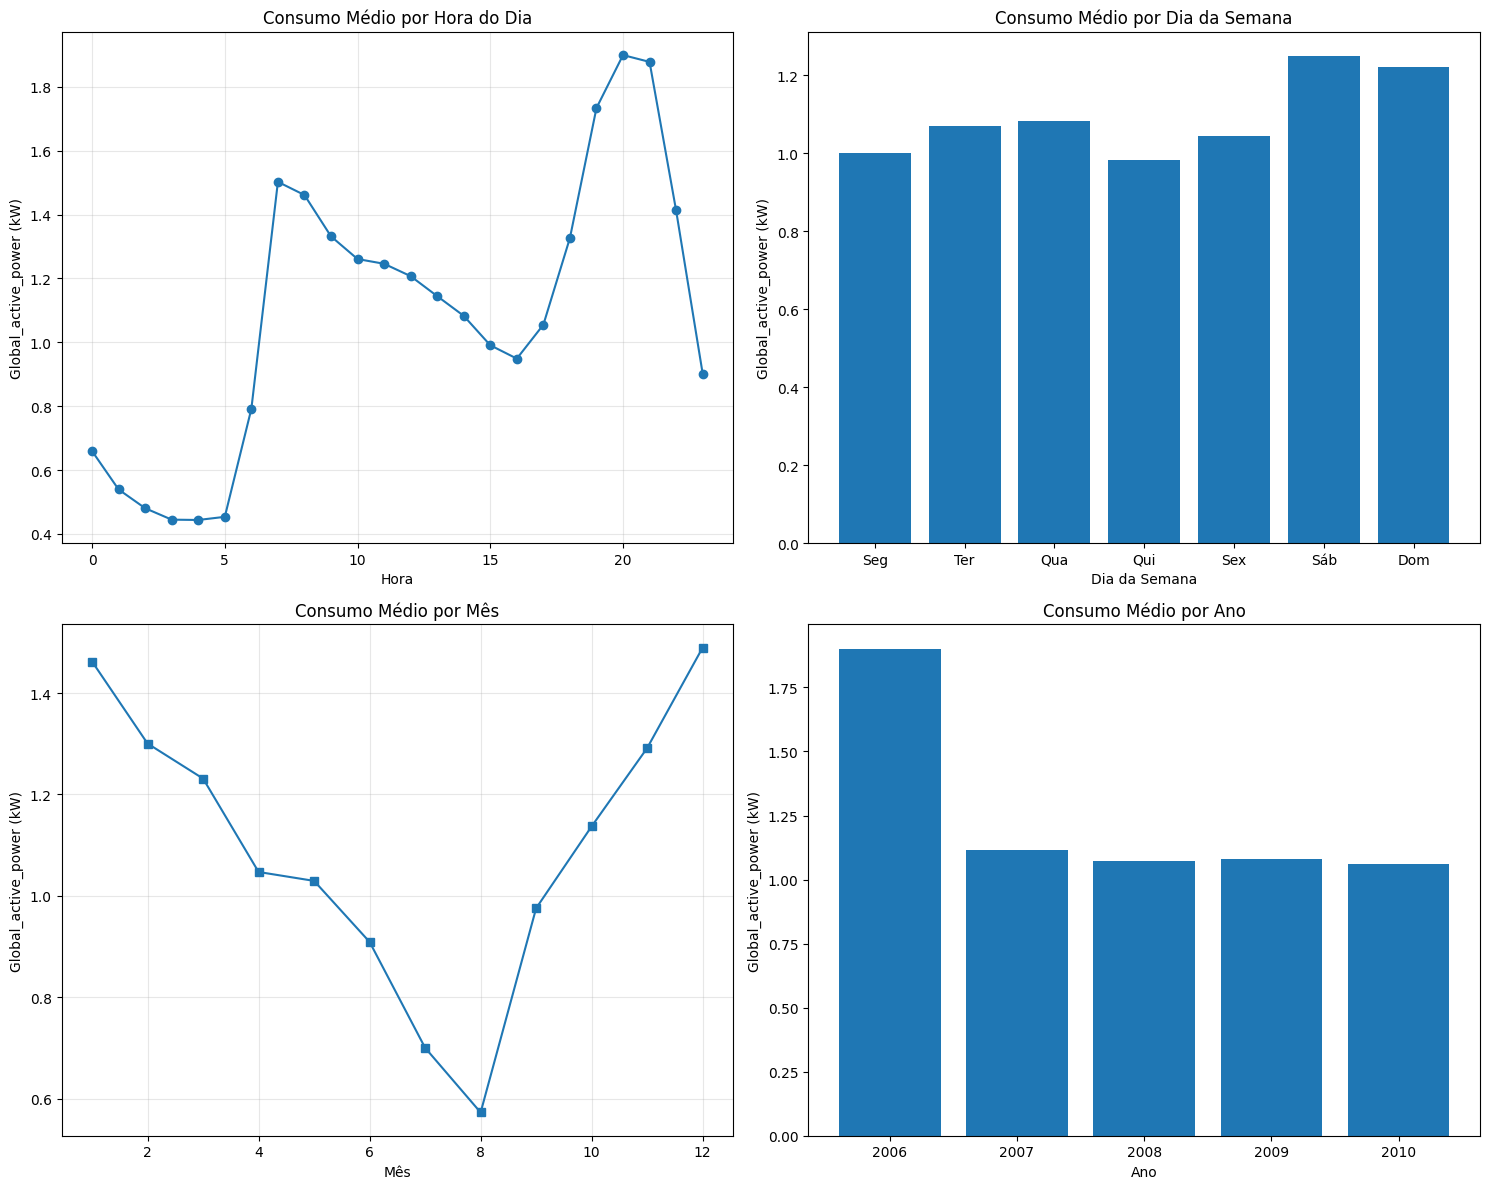

In [10]:
# Análise de padrões temporais
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker="o")
axes[0, 0].set_title("Consumo Médio por Hora do Dia")
axes[0, 0].set_xlabel("Hora")
axes[0, 0].set_ylabel(f"{Y} (kW)")
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].bar(range(7), daily_avg.values)
axes[0, 1].set_title("Consumo Médio por Dia da Semana")
axes[0, 1].set_xlabel("Dia da Semana")
axes[0, 1].set_ylabel(f"{Y} (kW)")
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)


axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker="s")
axes[1, 0].set_title("Consumo Médio por Mês")
axes[1, 0].set_xlabel("Mês")
axes[1, 0].set_ylabel(f"{Y} (kW)")
axes[1, 0].grid(True, alpha=0.3)

# Consumo médio por ano
yearly_avg = df_temporal.groupby("year")[Y].mean()
axes[1, 1].bar(yearly_avg.index, yearly_avg.values)
axes[1, 1].set_title("Consumo Médio por Ano")
axes[1, 1].set_xlabel("Ano")
axes[1, 1].set_ylabel(f"{Y} (kW)")

plt.tight_layout()
plt.show()

In [11]:
# Preparação dos dados para modelagem

# Criar dataset com features temporais
df_model = df.copy()

# Adicionar features temporais
df_model["hour"] = df_model.index.hour
df_model["day_of_week"] = df_model.index.day_of_week
df_model["month"] = df_model.index.month
df_model["is_weekend"] = (df_model.index.day_of_week >= 5).astype(int)

# Adicionar features de lag (valores anteriores)
df_model["Global_active_power_lag1"] = df_model["Global_active_power"].shift(1)

# Adicionar médias móveis
df_model["Global_active_power_ma_60"] = (
    df_model["Global_active_power"].rolling(window=60).mean()
)

# Remover linhas com valores nulos criados pelas features de lag e médias móveis
df_model_clean = df_model.dropna()

print("=== PREPARAÇÃO DOS DADOS ===")
print(f"Shape original: {df.shape}")
print(f"Shape após engenharia de features: {df_model.shape}")
print(f"Shape após remoção de nulos: {df_model_clean.shape}")
print(f"Linhas removidas: {len(df_model) - len(df_model_clean)}")

# Mostrar as primeiras linhas
print("\nPrimeiras linhas do dataset preparado:")
df_model_clean.head()

=== PREPARAÇÃO DOS DADOS ===
Shape original: (2075259, 7)
Shape após engenharia de features: (2075259, 13)
Shape após remoção de nulos: (2045179, 13)
Linhas removidas: 30080

Primeiras linhas do dataset preparado:


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,is_weekend,Global_active_power_lag1,Global_active_power_ma_60
Datetime,,,,,,,,,,,,,
2006-12-16 18:23:00,2.926,0.0,235.679993,12.400000,0.0,1.0,17.0,18,5,12,1,2.934,4.103600
2006-12-16 18:24:00,3.452,0.0,235.199997,15.200000,0.0,1.0,17.0,18,5,12,1,2.926,4.090867
2006-12-16 18:25:00,4.870,0.0,233.740005,20.799999,0.0,1.0,17.0,18,5,12,1,3.452,4.082700
2006-12-16 18:26:00,4.868,0.0,233.839996,20.799999,0.0,1.0,17.0,18,5,12,1,4.870,4.074267
2006-12-16 18:27:00,4.866,0.0,233.789993,20.799999,0.0,1.0,17.0,18,5,12,1,4.868,4.065567


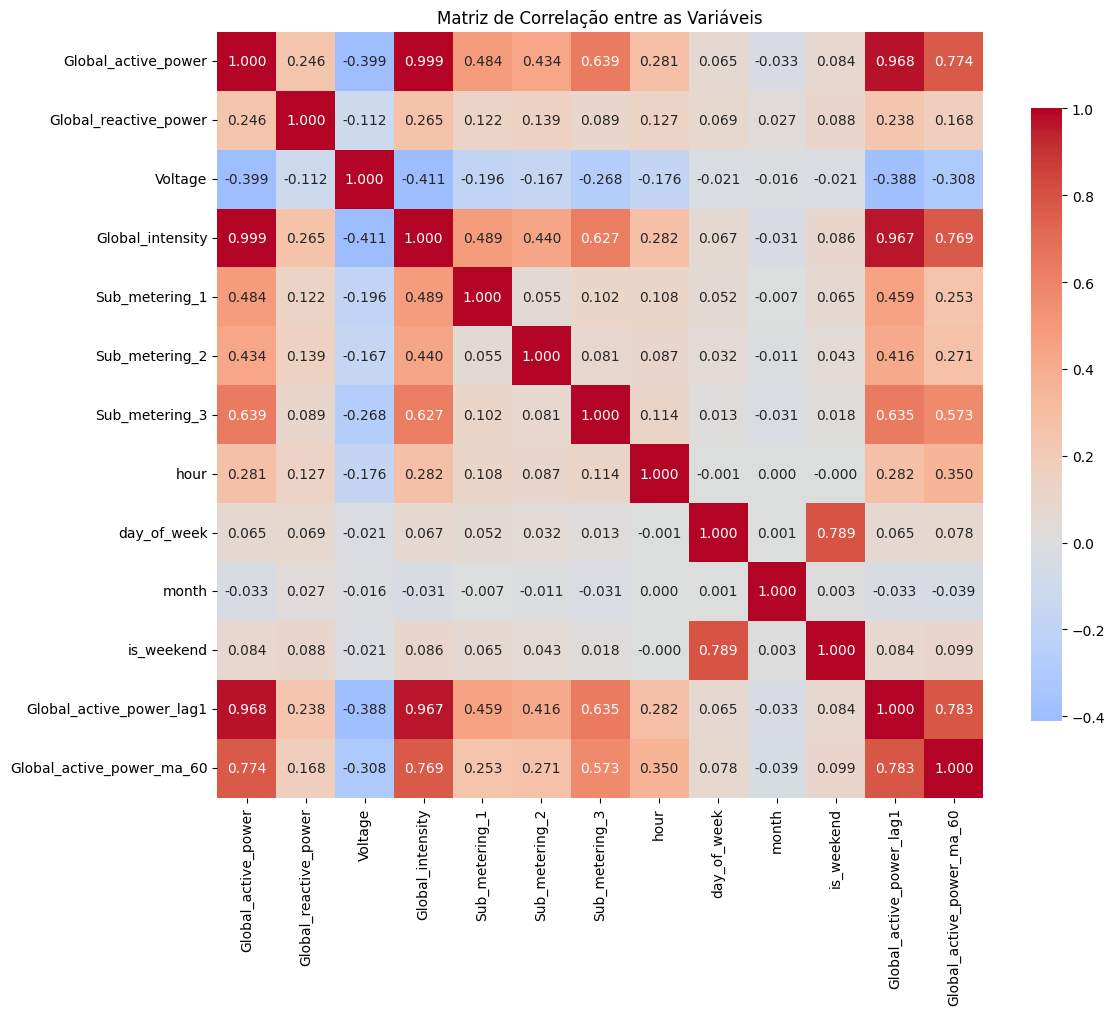

In [12]:
import seaborn as sns

correlation_matrix = df_model_clean.corr()

# Visualização da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    square=True,
    fmt=".3f",
    cbar_kws={"shrink": 0.8},
)
plt.title("Matriz de Correlação entre as Variáveis")
plt.tight_layout()
plt.show()